# UJIIndoorLoc

In [158]:

import os


requirements_path = os.path.join(os.getcwd(), 'requirements.txt')

os.system(f'pip install -r {requirements_path}')
print("All dependencies have been installed.")

All dependencies have been installed.


In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#import sklearn measures




# 1. Read Data into Dataframe

In [160]:
datafolder = "../../datasets/UJIIndoorLoc"

trainfile = os.path.join(datafolder, "trainingData.csv")
validfile = os.path.join(datafolder, "validationData.csv")

#read data into pandas dataframes
train_data = pd.read_csv(trainfile)
test_data = pd.read_csv(validfile)
print("Training data shape:", train_data.shape)
test_data.head()




Training data shape: (19937, 529)


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7515.916799,4.864890e+06,1,1,0,0,0,0,1380872703
1,100,100,100,100,100,100,100,100,100,100,...,100,-7383.867221,4.864840e+06,4,2,0,0,0,13,1381155054
2,100,100,100,100,100,100,100,100,100,100,...,100,-7374.302080,4.864847e+06,4,2,0,0,0,13,1381155095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7365.824883,4.864843e+06,4,2,0,0,0,13,1381155138
4,100,100,100,100,100,100,100,100,100,100,...,100,-7641.499303,4.864922e+06,2,0,0,0,0,2,1380877774


In [161]:
# Response variables in our problem are Building, Floor, Latitude, Longitude and Relative Position
train_data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']].astype(str).describe(include=['object'])
test_data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']].astype(str).describe(include=['object'])

## X and Y-data split
# Features are the WAP columns
X_train = train_data.iloc[:,:520]
X_test = test_data.iloc[:,:520]

# Select FLOOR and BUILDINGID for location prediction
y_train = train_data[['FLOOR', 'BUILDINGID', 'SPACEID']].copy()
y_test  = test_data[['FLOOR', 'BUILDINGID']].copy()
y_train_new_predict = y_train.copy()

print(y_test.head())

#histogram of space ids for test set
# Combine BUILDINGID and FLOOR into a simpler location code
# Format: "B{BUILDING}F{FLOOR}" for better readability
y_train_new_predict['LOC_CODE'] = (y_train['BUILDINGID'].astype(str) + 
                       y_train['FLOOR'].astype(str)+
                       y_train['SPACEID'].astype(str)
                       )
y_train['LOC_CODE'] = (y_train['BUILDINGID'].astype(str) + 
                       y_train['FLOOR'].astype(str)
                       )
y_test['LOC_CODE'] = (y_test['BUILDINGID'].astype(str) + 
                      y_test['FLOOR'].astype(str) 
                      )

# Keep only the combined column
y_train = y_train[['LOC_CODE']].astype('category')
y_test  = y_test[['LOC_CODE']].astype('category')
y_train_new_predict = y_train_new_predict[['LOC_CODE']].astype('category')

y_train_new_predict.head()


   FLOOR  BUILDINGID
0      1           1
1      4           2
2      4           2
3      4           2
4      2           0


,LOC_CODE
0,12106
1,12106
2,12103
3,12102
4,00122


# 2. Exploratory Data Analysis

In [162]:
# Replace the 100 values with NaN for further processing
# Transform Train data
X_train = (X_train
             .replace(to_replace=100,value=np.nan))

# Perform the same transform on Test data
X_test = (X_test
             .replace(to_replace=100,value=np.nan))

### drop NaN and show distribution

count    358763.000000
mean        -78.497211
std          12.615758
min        -104.000000
25%         -88.000000
50%         -82.000000
75%         -72.000000
max           0.000000
dtype: float64

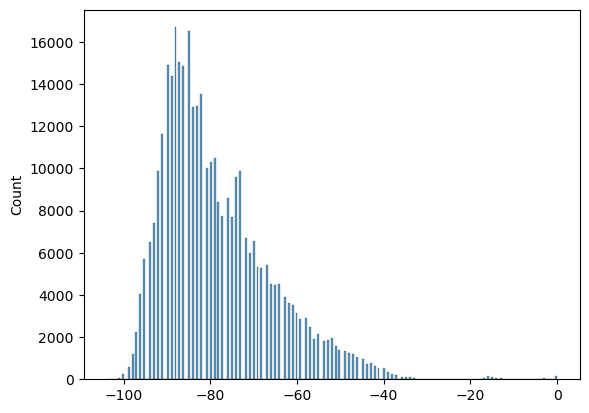

In [163]:
X_stack = X_train.stack(future_stack=True)
sns.histplot(X_stack.dropna(),kde = False)
X_stack.describe()

In [164]:
# Proportion of out of range values
sum(X_stack.isnull() == 0)/len(X_stack)

0.03460544947353394

In [165]:
# Removing columns with all NaN values
all_nan = (X_train
           .isnull()
           .all(axis=0) == False)
filtered_cols = (all_nan[all_nan]
                 .index
                 .values)

print("Before removing predictors with no in-range values", X_train.shape)

X_train = X_train.loc[:,filtered_cols]
X_test = X_test.loc[:,filtered_cols]

print("After removing predictors with no in-range values", X_train.shape)

Before removing predictors with no in-range values (19937, 520)
After removing predictors with no in-range values (19937, 465)


In [166]:
X_raw_train = X_train
X_raw_test = X_test

X_raw_combined = pd.concat([X_raw_train, X_raw_test], axis=0)
Y_raw_combined = pd.concat([y_train, y_test], axis=0)

#new test train split
X_train_tot_split, X_test__tot_split, Y_train_tot_split, Y_test__tot_split = train_test_split(X_raw_combined, Y_raw_combined, test_size=0.2, random_state=42)
X_train_split_new, X_test_split_new, Y_train_split_new, Y_test_split_new = train_test_split(X_raw_train, y_train_new_predict, test_size=0.2, random_state=42)
#fill for SCaling
X_train_noNAN = X_train.fillna(-110)
X_test_noNAN = X_test.fillna(-110)


X_raw_train.shape, X_raw_test.shape, X_train_split_new.shape, X_test_split_new.shape, Y_train_split_new.shape, Y_test_split_new.shape


((19937, 465), (1111, 465), (15949, 465), (3988, 465), (15949, 1), (3988, 1))

count    1111.000000
mean       15.591359
std         6.233626
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        33.000000
dtype: float64

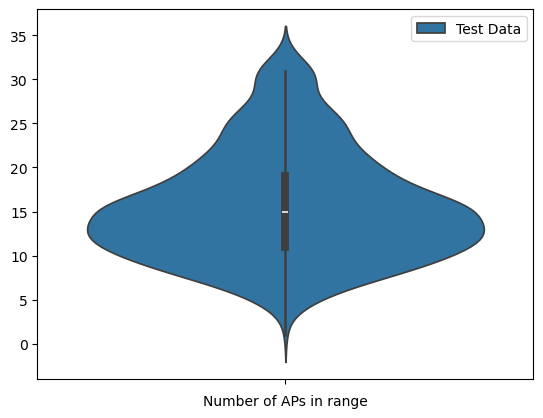

In [167]:
waps_in_range_train = (X_train
                 .notnull()
                 .sum(axis = 1))

waps_in_range_test = (X_test
                 .notnull()
                 .sum(axis = 1))

waps_in_range_tot_train_split = (X_train_tot_split
                 .notnull() 
                 .sum(axis = 1))
waps_in_range_tot_test_split = (X_test__tot_split
                 .notnull() 
                 .sum(axis = 1))

fig, ax = plt.subplots(1,1)


sns.violinplot(waps_in_range_test, ax = ax, label = 'Test Data')
ax.set_xlabel("Number of APs in range")
ax.legend()
waps_in_range_test.describe()

count    19937.000000
mean        17.994834
std          7.333575
min          0.000000
25%         13.000000
50%         17.000000
75%         22.000000
max         51.000000
dtype: float64

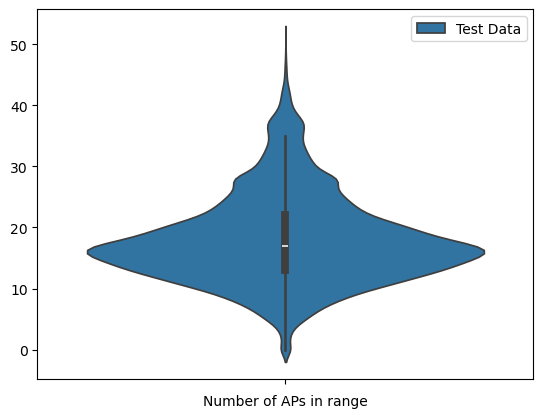

In [168]:
fig, ax = plt.subplots(1,1)


sns.violinplot(waps_in_range_train, ax = ax, label = 'Test Data')
ax.set_xlabel("Number of APs in range")
ax.legend()
waps_in_range_train.describe()

count    4210.000000
mean       17.778860
std         7.245633
min         0.000000
25%        13.000000
50%        17.000000
75%        21.000000
max        49.000000
dtype: float64

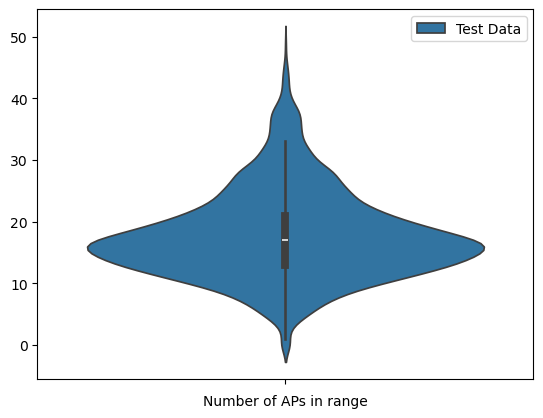

In [169]:
fig, ax = plt.subplots(1,1)


sns.violinplot(waps_in_range_tot_test_split, ax = ax, label = 'Test Data')
ax.set_xlabel("Number of APs in range")
ax.legend()
waps_in_range_tot_test_split.describe()

count    16838.000000
mean        17.890248
std          7.312768
min          0.000000
25%         13.000000
50%         17.000000
75%         21.000000
max         51.000000
dtype: float64

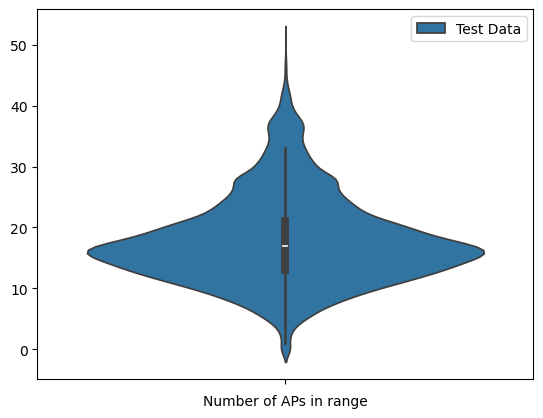

In [170]:
fig, ax = plt.subplots(1,1)


sns.violinplot(waps_in_range_tot_train_split, ax = ax, label = 'Test Data')
ax.set_xlabel("Number of APs in range")
ax.legend()
waps_in_range_tot_train_split.describe()

## 3. Feature scaling

<Axes: ylabel='Count'>

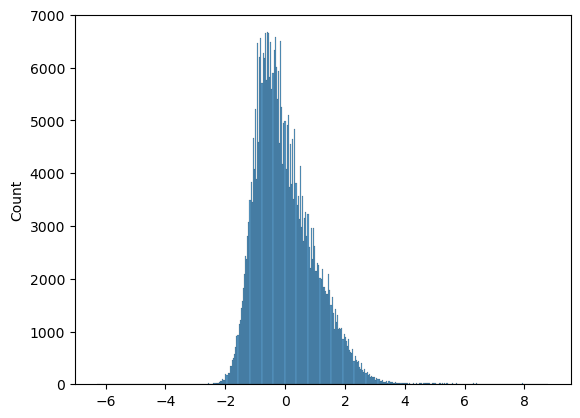

In [171]:

sc = StandardScaler()
X_std_train = sc.fit_transform(X_raw_train)
X_std_test = sc.transform(X_raw_test)

X_std_train = pd.DataFrame(X_std_train)
X_std_test = pd.DataFrame(X_std_test)

##plotting standardized data distribution
X_stack_std = X_std_train.stack(future_stack=True)
sns.histplot(X_stack_std.dropna(),kde = False)


## Random Forest can work with NaNs

In [172]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Convert categorical LOC_CODE to numeric codes
y_train_codes = y_train['LOC_CODE'].cat.codes
y_test_codes = y_test['LOC_CODE'].cat.codes
Y_train_tot_split_codes = Y_train_tot_split['LOC_CODE'].cat.codes
Y_test__tot_split_codes = Y_test__tot_split['LOC_CODE'].cat.codes

print(f"Number of unique locations: {y_train['LOC_CODE'].nunique()}")
print(f"Training samples: {len(y_train_codes)}, Test samples: {len(y_test_codes)}")

# Train classifier with scaling
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf.fit(X_std_train, y_train_codes)

clf_wo_scaling = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf_wo_scaling.fit(X_raw_train, y_train_codes)

clf_woscaling_newsplit = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf_woscaling_newsplit.fit(X_train_tot_split, Y_train_tot_split_codes)

# Predict on test set
y_pred = clf.predict(X_std_test)
y_pred_wo_scaling = clf_wo_scaling.predict(X_raw_test)
y_pred_woscaling_newsplit = clf_woscaling_newsplit.predict(X_test__tot_split)

# Evaluate
accuracy = accuracy_score(y_test_codes, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report with Scaling:")
accuracy_wo_scaling = accuracy_score(y_test_codes, y_pred_wo_scaling)
accuracy_woscaling_newsplit = accuracy_score(Y_test__tot_split_codes, y_pred_woscaling_newsplit)
classification_report = classification_report(y_test_codes, y_pred_wo_scaling, target_names=y_train['LOC_CODE'].cat.categories)
#print(classification_report)
print(f"\nAccuracy without Scaling: {accuracy_wo_scaling:.4f}")
print(f"\nAccuracy with new train/test split: {accuracy_woscaling_newsplit:.4f}")
print("\nClassification Report without Scaling:")

# Show some example predictions
comparison = pd.DataFrame({
    'True': y_test['LOC_CODE'].values[:10],
    'Predicted': y_train['LOC_CODE'].cat.categories[y_pred[:10]]
})
print("\nFirst 10 predictions:")
print(comparison)








Number of unique locations: 13
Training samples: 19937, Test samples: 1111

Accuracy: 0.9064

Classification Report with Scaling:

Accuracy without Scaling: 0.9064

Accuracy with new train/test split: 0.9933

Classification Report without Scaling:

First 10 predictions:
  True Predicted
0   11        13
1   24        24
2   24        24
3   24        24
4   02        02
5   22        22
6   23        23
7   23        23
8   22        22
9   20        20


In [177]:
clf_woscaling_sapceid = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf_woscaling_sapceid.fit(X_train_split_new, Y_train_split_new['LOC_CODE'].cat.codes)
y_pred_woscaling_spaceid = clf_woscaling_sapceid.predict(X_test_split_new)
accuracy_woscaling_spaceid = accuracy_score(Y_test_split_new['LOC_CODE'].cat.codes, y_pred_woscaling_spaceid)
print(f"\nAccuracy without Scaling with SPACEID: {accuracy_woscaling_spaceid:.4f}") 

# Get unique labels present in both test and predictions
unique_labels = np.unique(np.concatenate([Y_test_split_new['LOC_CODE'].cat.codes, y_pred_woscaling_spaceid]))

# Create mapping from codes to category names, handling out-of-range codes
all_categories = Y_train_split_new['LOC_CODE'].cat.categories
target_names = []
for code in unique_labels:
	if code < len(all_categories):
		target_names.append(all_categories[code])
	else:
		target_names.append(f"Unknown_{code}")

classification_report_spaceid = classification_report(
	Y_test_split_new['LOC_CODE'].cat.codes, 
	y_pred_woscaling_spaceid, 
	labels=unique_labels,
	target_names=target_names,
	zero_division=0
)
print(classification_report_spaceid)


Accuracy without Scaling with SPACEID: 0.8651
              precision    recall  f1-score   support

       00102       1.00      0.83      0.91         6
       00106       1.00      1.00      1.00         1
       00107       1.00      1.00      1.00         3
       00110       1.00      1.00      1.00         4
       00111       0.50      0.25      0.33         4
       00112       0.67      1.00      0.80         4
       00113       0.75      0.75      0.75         4
       00114       1.00      1.00      1.00         5
       00115       1.00      0.75      0.86         4
       00116       0.50      1.00      0.67         1
       00117       0.00      0.00      0.00         1
       00118       1.00      1.00      1.00         5
       00119       0.83      0.83      0.83         6
       00120       0.80      1.00      0.89         4
       00121       0.75      1.00      0.86         3
       00122       1.00      0.88      0.93         8
       00123       0.56      0.83 

In [ ]:
sc = StandardScaler()
X_std_train_noNAN = sc.fit_transform(X_train_noNAN)
X_std_test_noNAN = sc.transform(X_test_noNAN)

X_std_train_noNAN = pd.DataFrame(X_std_train_noNAN)
X_std_test_noNAN = pd.DataFrame(X_std_test_noNAN)

#plot standardized data distribution
X_stack_std_noNAN = X_std_train_noNAN.stack(future_stack=True)
##sns.histplot(X_stack_std_noNAN,kde = False) not needed since NAN dominates

## KNN-Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Convert categorical LOC_CODE to numeric codes
y_train_codes = y_train['LOC_CODE'].cat.codes
y_test_codes = y_test['LOC_CODE'].cat.codes
# Train classifier
knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_clf.fit(X_std_train_noNAN, y_train_codes)

knn_clf_wo_scaling = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_clf_wo_scaling.fit(X_train_noNAN, y_train_codes)
# Predict on test set
y_pred_knn = knn_clf.predict(X_std_test_noNAN)
y_pred_knn_wo_scaling = knn_clf_wo_scaling.predict(X_test_noNAN)
# Evaluate
accuracy_knn = accuracy_score(y_test_codes, y_pred_knn)
print(f"\nKNN Accuracy: {accuracy_knn:.4f}")
print("\nKNN Classification Report with Scaling:")
accuracy_knn_wo_scaling = accuracy_score(y_test_codes, y_pred_knn_wo_scaling)
print(f"\nKNN Accuracy without Scaling: {accuracy_knn_wo_scaling:.4f}")
print("\nKNN Classification Report without Scaling:")



classification_report_knn = classification_report(y_test_codes, y_pred_knn_wo_scaling, target_names=y_train['LOC_CODE'].cat.categories)
print(classification_report_knn)


KNN Accuracy: 0.7903

KNN Classification Report with Scaling:

KNN Accuracy without Scaling: 0.8875

KNN Classification Report without Scaling:
              precision    recall  f1-score   support

          00       0.96      0.94      0.95        78
          01       0.96      0.98      0.97       208
          02       0.97      0.96      0.96       165
          03       1.00      0.98      0.99        85
          10       0.83      0.67      0.74        30
          11       0.95      0.63      0.76       143
          12       0.58      0.85      0.69        87
          13       0.71      0.96      0.82        47
          20       0.85      0.92      0.88        24
          21       0.95      0.97      0.96       111
          22       0.98      0.76      0.85        54
          23       0.72      0.97      0.83        40
          24       0.97      0.77      0.86        39

    accuracy                           0.89      1111
   macro avg       0.88      0.87      0.87

## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_std_train_noNAN, y_train_codes)
y_pred_xgb = xgb_clf.predict(X_std_test_noNAN)
accuracy_xgb = accuracy_score(y_test_codes, y_pred_xgb)
print(f"\nXGBoost Accuracy: {accuracy_xgb:.4f}")

xgb_clf_wo_scaling = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf_wo_scaling.fit(X_train_noNAN, y_train_codes)
y_pred_xgb_wo_scaling = xgb_clf_wo_scaling.predict(X_test_noNAN)
accuracy_xgb_wo_scaling = accuracy_score(y_test_codes, y_pred_xgb_wo_scaling)
print(f"\nXGBoost Accuracy without Scaling: {accuracy_xgb_wo_scaling:.4f}")

classification_report_xgb = classification_report(y_test_codes, y_pred_xgb_wo_scaling, target_names=y_train['LOC_CODE'].cat.categories)
print("\nXGBoost Classification Report without Scaling:")
print(classification_report_xgb)


XGBoost Accuracy: 0.8929

XGBoost Accuracy without Scaling: 0.8929

XGBoost Classification Report without Scaling:
              precision    recall  f1-score   support

          00       0.95      0.92      0.94        78
          01       0.97      0.93      0.95       208
          02       0.90      0.97      0.94       165
          03       0.99      0.96      0.98        85
          10       0.78      0.70      0.74        30
          11       0.94      0.64      0.76       143
          12       0.62      0.94      0.75        87
          13       0.79      0.87      0.83        47
          20       1.00      0.88      0.93        24
          21       0.92      0.97      0.95       111
          22       0.96      0.89      0.92        54
          23       0.85      1.00      0.92        40
          24       1.00      0.82      0.90        39

    accuracy                           0.89      1111
   macro avg       0.90      0.88      0.88      1111
weighted avg      

In [ ]:
## Performe KFold Cross-Validation for XGBoost
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_std_train_noNAN):
    X_train_fold, X_val_fold = X_std_train_noNAN.iloc[train_index], X_std_train_noNAN.iloc[val_index]
    y_train_fold, y_val_fold = y_train_codes.iloc[train_index], y_train_codes.iloc[val_index]
    
    xgb_clf_fold = XGBClassifier(eval_metric='mlogloss', random_state=42)
    xgb_clf_fold.fit(X_train_fold, y_train_fold)
    y_val_pred = xgb_clf_fold.predict(X_val_fold)
    y_test_pred = xgb_clf_fold.predict(X_std_test_noNAN)

    test_accuracy = accuracy_score(y_test_codes, y_test_pred)
    fold_accuracy = accuracy_score(y_val_fold, y_val_pred)
    print(f"Fold Accuracy: {fold_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

Fold Accuracy: 0.9987
Test Accuracy: 0.9028
Fold Accuracy: 0.9982
Test Accuracy: 0.8938
Fold Accuracy: 0.9985
Test Accuracy: 0.9028
Fold Accuracy: 0.9980
Test Accuracy: 0.8965
Fold Accuracy: 0.9980
Test Accuracy: 0.8947



Validation Accuracy (Train-Test Split): 0.9050

XGBoost Classification Report (Train-Test Split):
              precision    recall  f1-score   support

          00       0.98      0.87      0.92      1025
          01       0.90      0.90      0.90      1315
          02       0.78      0.86      0.82      1399
          03       0.91      0.83      0.87      1359
          10       0.86      0.89      0.88      1338
          11       0.86      0.90      0.88      1443
          12       0.89      0.83      0.85      1355
          13       0.81      0.88      0.84       880
          20       0.95      0.98      0.97      1847
          21       0.95      0.93      0.94      2094
          22       0.93      0.90      0.91      1529
          23       0.95      0.96      0.96      2610
          24       0.94      0.93      0.94      1072

    accuracy                           0.91     19266
   macro avg       0.90      0.90      0.90     19266
weighted avg       0.91      0.91  

Text(95.72222222222221, 0.5, 'True')

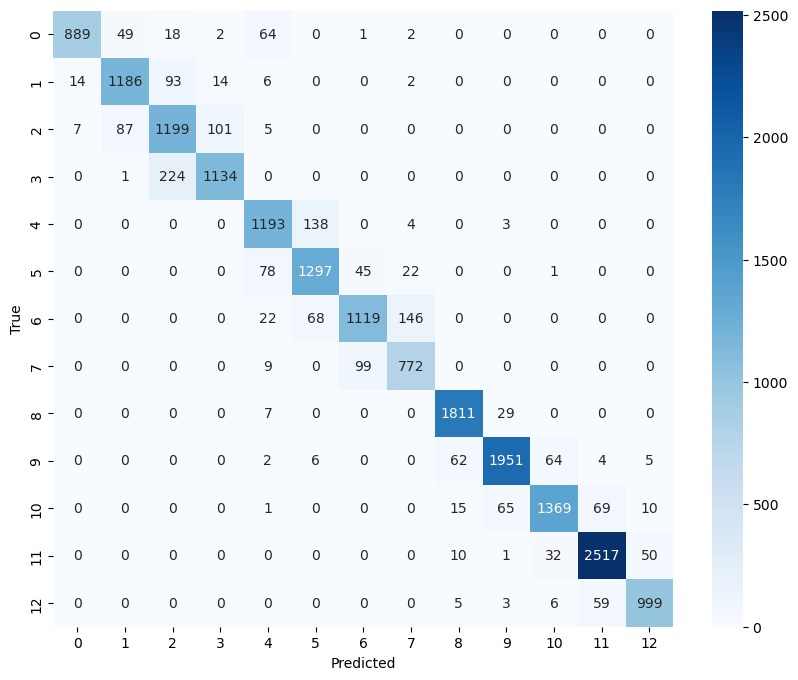

In [ ]:
## Train Test Split Validation for XGBoost
from sklearn.metrics import confusion_matrix
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_std_train_noNAN, y_train_codes, test_size=0.97, random_state=42
)   
xgb_clf_split = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf_split.fit(X_train_split, y_train_split)
y_val_pred_split = xgb_clf_split.predict(X_val_split)
val_accuracy_split = accuracy_score(y_val_split, y_val_pred_split)
print(f"\nValidation Accuracy (Train-Test Split): {val_accuracy_split:.4f}")

classification_report_split = classification_report(y_val_split, y_val_pred_split, target_names=y_train['LOC_CODE'].cat.categories)
print("\nXGBoost Classification Report (Train-Test Split):")
print(classification_report_split)

confusion_matrix_split = confusion_matrix(y_val_split, y_val_pred_split)
print("\nXGBoost Confusion Matrix (Train-Test Split):")
print(confusion_matrix_split)

#plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_split, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')